# Non-parametric Density Estimation

Guillermo Cabrera Vives

guillecabrera@udec.cl

### Announcements:

*Papers schedule*:
* Martes 11/7/17: Isaias Huerta, Danny Luarte
* Martes 11/14/17: Alexis Sanchez Cecilia Huerta
* Viernes 11/17/17: Monserrat Martinez, Felipe Glaria
* Martes 11/21/17: Diego Rodríguez, Aldo Concha, Mabel Vidal
* Viernes 11/24/17: Manuel Pérez, Cristóbal Donoso
* Martes 11/28/17: Joaquín Cárdenas, Jaime Jiménez, Leonard Zwerenz

## Density Estimation

The goal of density estimation is to build a probability density function by using data.

<img src=images/density_estimation.png />

### Histograms

0.33818287
6662


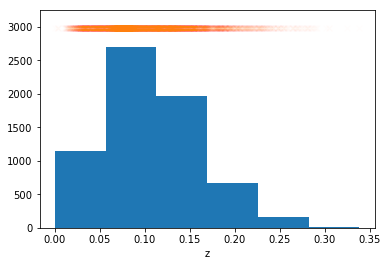

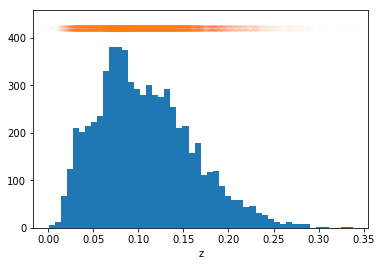

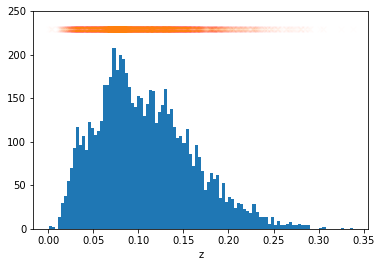

In [1]:
import pandas as pd
import numpy as np
import pylab as pl

df = pd.read_csv("data/SDSS_gals.csv")
print df['z'].max()
z = np.array(df['z'])
#z = np.array(df.sample(100)['z'])
print len(z)
bins = [6, 50, 100]

for b in bins:
    n, _, _ = pl.hist(z, bins = b)
    pl.plot (z, np.ones(len(z))*n.max()*1.1, "x", alpha = 0.01)
    pl.ylim([0, n.max()*1.2])
    pl.xlabel("z")
    pl.show()

How do we choose the number of bins / bins size?
* Assuming an underlying Gaussian distribution: Scott's rule: $h=3.5\sigma/N^{1/3}$, where $\sigma$ is the sample standard deviation and $N$ the number of data points.
* non-Gaussian distributions: Freedman-Diaconis rule: $h= 2(q_{75}-q_{25})/N^{1/3}$, where $q_{75}$ and $q_{25}$ are quartiles 75 and 25 respectively.
* cross-validation (much more expensive).


### Kernel Density Estimation 

* "Non-parametric” density estimation.
* Each data point is described by a kernel.
* The probability density function is estimated as the sum of the kernels
* $\hat{f}_h(x) = \frac{1}{n}\sum K_h(x-x_i) = \frac{1}{nh}\sum K(\frac{x-x_i}{h})$
* $h$ is the badwidth parameter that defines the size of the Kernel. 

<img src=images/KDE1.png><img src=images/KDE2.png>

(6662,)
bins =  34


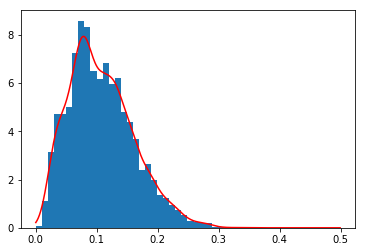

In [2]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth = 1e-2)
print z.shape
kde.fit(z[:, None])

x = np.arange(0, 0.5, 0.001)
pdf = np.exp(kde.score_samples (x[:, None]))

# histogram "Scott's rule"
dh = 3.5 * z.std()/(len(z)**(1./3.))
bins = np.round((z.max() - z.min())/dh).astype(int)
print "bins = ", bins

pl.clf()
pl.hist(z, bins = bins, normed = True)
pl.plot(x, pdf, "r")
pl.show()

## Selecting $h$ using cross-validation

### Mean integrated square error

As we noticed, the value of $h$ can have a big impact on our probability density function. In order to select a suitable bandwidth $h$, we minimize the mean integrated squared error (mise):

MISE$_h$ = $\int(\hat{f}_h(x) - f(x))^2dx = \int\hat{f}_h^2dx - 2\int\hat{f}_hf(x)dx + \int f^2(x)dx$

* $\int\hat{f}_h^2dx$ computable from the data
* $\int f^2(x)dx$ does not depend on $h$
* $\int\hat{f}_hf(x)dx = \mathbb{E}_x(\hat{f}_h(x))$, where the expectation is computed with respect to an additional and independent observation $x$.

In order to estimate this last term, we define the _leave one out_ estimate 

$\hat{\mathbb{E}}_x(\hat{f}_h(x)) =  \frac{1}{n}\sum_{i = 1}^n \hat{f}_{h, -i}(x_i)$,

where $\hat{f}_{h, -i}(x)$ is the estimated density leaving out the $i$th data point. Using all this we can define the _cross-validation least-square score_

$CV(h) = \int\hat{f}_h^2(x)dx -\frac{2}{n}\sum_{i = 1}^n \hat{f}_{h, -i}(x_i)$,

and the optimum value of $h$ is found by

$\hat{h}_CV = $argmin$_h CV(h)$.

### Likelihood cross-validation

When doing density estimation we are actually estimating the pdf of our parameters. In that sense, we can use our test set (leave-one-out) to directly estimate the likelihood of that set of points. If we consider the likelihood cost for KDE, for which we have the leave-one-out likelihood cross-validation, then the cost is simply the sum over all points in the data s et (i.e., i = 1, . . . , N ) of the log of the likelihood of the density, where the density,
$\hat{f}_{h,−i} (x_i)$, is estimated leaving out the i th data point.

$CV_l(h) = \frac{1}{N}\sum_{i=1}^N\log{\hat{f}_{h,−i} (x_i)}$

and the optimum value of $h$ is found by

$\hat{h}_CV_l = $argmax$_h CV_l(h)$.

/Users/guille/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


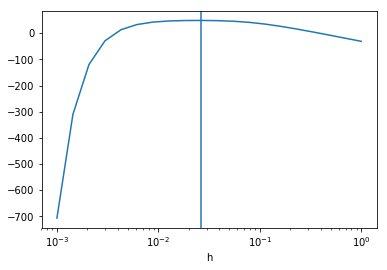

/Users/guille/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/guille/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


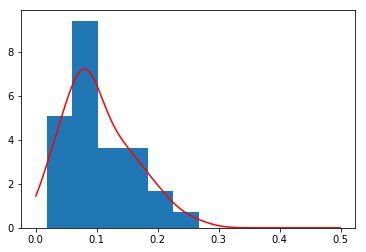

In [3]:
from sklearn.model_selection import GridSearchCV

#z = np.array(df['z'])
z = np.array(df.sample(100)['z'])

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-3, 0, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(z[:, None])

# We extract just the scores (total log probability under the model.)
scores = [x[1] for x in grid.grid_scores_]

pl.clf()
pl.plot(params['bandwidth'], scores)
pl.xlabel ("h")
pl.axvline(grid.best_estimator_.bandwidth)
pl.xscale("log")
pl.show()

x = np.arange(0, 0.5, 0.001)
pdf = np.exp(grid.best_estimator_.score_samples (x[:, None]))

# histogram "Scott's rule"
dh = 3.5 * z.std()/(len(z)**(1./3.))
bins = np.round((z.max() - z.min())/dh)

pl.clf()
pl.hist(z, bins = bins, normed = True)
pl.plot(x, pdf, "r")
pl.show()


Lets do something a bit more interesting: density of galaxies in terms of their radius and magnitude (and redshift).

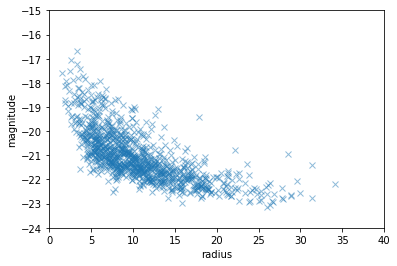

In [4]:
sample_1000 = df.sample(1000)
data = np.array([np.array(sample_1000['petroRad_r_kpc']), np.array(sample_1000['absPetroMag_r'])]).transpose()

pl.clf()
pl.plot(data[:, 0], data[:, 1], "x", alpha = 0.5)
pl.xlim([0, 40])
pl.ylim([-24, -15])
pl.xlabel("radius")
pl.ylabel("magnitude")
pl.show()


(1800, 2)


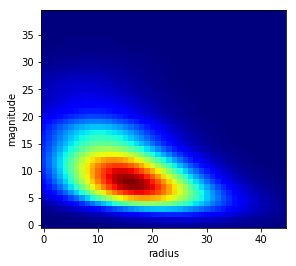

In [5]:
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-3, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

x = np.arange(.0, 40, 1)
y = np.arange(-24, -15, 0.2)
#x = np.arange(.0, 40, 0.1)
#y = np.arange(-24, -15, 0.02)
X, Y = np.meshgrid(x, y)
XY = np.array([X.flatten(), Y.flatten()]).transpose()
print XY.shape
pdf = np.exp(grid.best_estimator_.score_samples (XY)).reshape(X.shape)

pl.clf()
pl.imshow(pdf.transpose(), interpolation='none', cmap=pl.cm.jet, origin='lower',clip_on=True)
pl.xlabel("radius")
pl.ylabel("magnitude")
pl.show()
    


KernelDensity(algorithm='auto', atol=0, bandwidth=1.4384498882876631,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)
(1000, 2) [  9.37027562 -20.32945615]


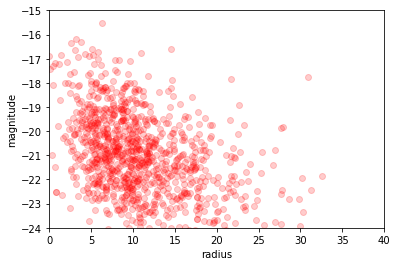

In [6]:
# Once the model is fitted we can even sample from it!
print grid.best_estimator_
new_data = grid.best_estimator_.sample(1000, random_state=0)
print new_data.shape, new_data[0]

pl.clf()
pl.plot(new_data[:, 0], new_data[:, 1], "ro", alpha = 0.2)
pl.xlabel("radius")
pl.ylabel("magnitude")
pl.xlim([0, 40])
pl.ylim([-24, -15])
pl.show()


### Gaussian Mixture Model

<img src=images/GMM1.png style="height: 200px;"><img src=images/GMM2.png style="height: 200px;"><img src=images/GMM3.png style="height: 200px;">

latent variable: $z\in \{e_1, \ldots, e_m\}$

$e_1 = (1, 0, 0,\ldots, 0), \cdots, e_m = (0, 0, 0,\ldots, 1)$

$P(z=e_k) = \alpha_k$

$p(\boldsymbol{x}|z = e_k) = N(\boldsymbol{x}|\mu_k, C_k)$

$p(\boldsymbol{x}) = \sum_zp(\boldsymbol{x}|z)P(z) = \sum_z\alpha_kN(\boldsymbol{x}|\boldsymbol{\mu}_k, C_k)$

$P(z=e_k|\boldsymbol{x}) = \frac{\alpha_kN(\boldsymbol{x}|\boldsymbol{\mu}_k, C_k)}{p(\boldsymbol{x})}$

#### Expectation-Maximization

* E-step: calculate the expected joint (data + latent variable) log-likelihood at iteration t.
* M-step: maximize such likelihood in terms of the model parameters.
  $\theta=(\alpha, \{\boldsymbol{\mu}_k\}, \{C_k\})$
  
How?

* $Z ={z_{i,k}}$ describes which Gaussian $k$ generated each sample $\boldsymbol{x}_i$.
* $z_{i,k} = 1$ if Gaussian $k$ emitted $\boldsymbol{x}_i$.
* Expected log-likelihood:

  $\mathbb{E}_Z[\log p(X, Z|\theta)|X, \theta^t]=\sum_{i,k}\mathbb{E}_Z[z_{i,k}|X, \theta^t]\log \alpha_k^t + \mathbb{E}_Z[z_{i,k}|X, \theta^t]\log N(\boldsymbol{x}|\mu_k^t, C_k^t)$

  $\mathbb{E}_Z[z_{i,k}|X, \theta^t]=\frac{\alpha_k^tN(\boldsymbol{x}_i|\mu_k^t, C_k^t)}{\sum_k\alpha_k^tN(\boldsymbol{x}_i|\mu_k^t, C_k^t)}$
* Maximization:

  $\theta^{t+1} = \mathrm{argmin}_\theta[\mathbb{E}_Z[\log p(X, Z|\theta)|X, \theta^t]]$
  
  $\mu_k^{t+1} = \frac{\sum_i \boldsymbol{x}_iP(z_k|\boldsymbol{x}_i, \theta^t)}{\sum_iP(z_k|\boldsymbol{x}_i, \theta^t)}$
  
  $C_k^{t+1} = \frac{\sum_iP(z_k|\boldsymbol{x}_i, \theta^t)(\boldsymbol{x}_i - \boldsymbol{\mu}_i)(\boldsymbol{x}_i - \boldsymbol{\mu}_i)^\top}{\sum_iP(z_k|\boldsymbol{x}_i, \theta^t)}$
  
  $\alpha_k^{t+1} = \frac{1}{N}\sum_iP(z_k|\boldsymbol{x}_i, \theta^t)$
  
How many Gaussians should we use?

## Model Selection

As we have seen before, in order to compare different models, the prefered technique is cross-validation. Nevertheless, there are classical methods that are easy to use and often effective for simple models. Two of those are the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

### Information Criteria

Consider $M$ parameters for the model and $N$ data points.

#### Akaike Information Criterion  

AIC $=2M-2\ln(L)$

* Based on information theory.
* Suppose that the data is generated by some unknown process $f$ and consider two candidate models $\hat{f}_1$ and $\hat{f}_2$. 
* If we knew $f$ we could infer which model is better by using the K-L divergence. But we don't know $f$.
* [Akaike](http://ieeexplore.ieee.org/document/1100705/) showed, that we can estimate, via AIC, how much more (or less) information is lost by $\hat{f}_1$ than by $\hat{f}_2$. 

#### Bayesian Information Criterion 

BIC $= -2\ln(L) + M\ln(M)$

* Asymptotic result derived under the assumptions that the data distribution is in an exponential family.
  * Exponential family: Given a measure $\eta$, we define an _exponential family of probability distributions_ as those  distributions whose density (relative to $\eta$) have the following general form:
  
    $ p(x|\eta) = h(x)\exp(\eta^\top T(x) - A(\eta))$
    
    for given functions $T$ and $h$ and $A(\eta)$ is the logarithm of a normalization factor.
* BIC is estimated from the Bayesian interpretation of the model:
\begin{eqnarray}
   -2\ln p(x|M) & = & -2\ln \int p(x|M, \theta)p(\theta)\\
   & \sim & -2\ln L + M(\ln (N) - \ln(2\pi))
   \end{eqnarray}

900.0


/Users/guille/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/guille/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


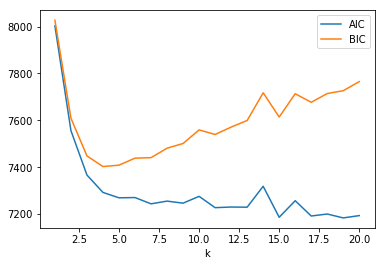

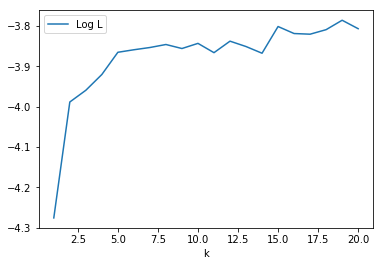

best model according to BIC with k =  4
(45, 40) (1800, 2)
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
(1800,)


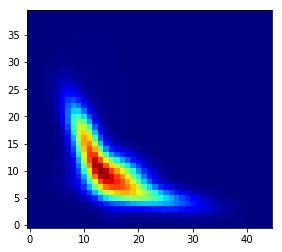

In [12]:
from sklearn.mixture import GaussianMixture # sklearn 0.18

N_train = 0.9*len(data)
print N_train
data_train = data[:N_train]
data_test = data[N_train:]

Ns = np.arange(20) + 1
models = [None for i in range(len(Ns))]

for i in range(len(Ns)):
    models[i] = GaussianMixture(Ns[i]).fit(data) # sklearn 0.18
    
# compute the AIC and the BIC
AIC = [m.aic(data_train) for m in models]
BIC = [m.bic(data_train) for m in models]

# compute the cross-validated log-likelihood
logL = [m.score(data_test).mean() for m in models]

# plot metrics in terms of k
pl.clf()
pl.plot(Ns, AIC, label = "AIC")
pl.plot(Ns, BIC, label = "BIC")
pl.xlabel("k")
pl.legend (loc = "best")
pl.show()

pl.clf()
pl.plot(Ns, logL, label = "Log L")
pl.xlabel("k")
pl.legend (loc = "best")
pl.show()

# plot the pdf of the best BIC model
print "best model according to BIC with k = ", Ns[np.argmin(BIC)]
print X.shape, XY.shape
print models[np.argmin(BIC)]
print models[np.argmin(BIC)].score_samples (XY).shape
pdf = np.exp(models[np.argmin(BIC)].score_samples (XY)).reshape(X.shape)

pl.clf()
pl.imshow(pdf.transpose(), interpolation='none', cmap=pl.cm.jet, origin='lower',clip_on=True)
pl.show()
